<a href="https://colab.research.google.com/github/MaximeRatel/Tarificateur-Auto/blob/master/BaseAuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importations

In [ ]:
%cd /content/drive/My Drive/Kaggle/BASEAUTO

import pandas as pd
import numpy as np
import pickle
import joblib
import time

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

import statsmodels.api as sm

from scipy import stats

from xgboost import XGBRegressor, plot_tree
import xgboost as xgb

import matplotlib.pyplot as plt

/content/drive/My Drive/Kaggle/BASEAUTO


# Fonctions

In [ ]:
list_num = ['PERMIS','ACV','AGECOND','RM','CLA','VIT','GARAGE']
list_cat = ['SEX','STATUT','CSP','USAGE','K8000','CAR','ALI','ENE','SEGM']

def conversion_var(df):
  """ Convertit les variables catégorielles et ordinales du jeu de données au format adéquat"""
  
  df['CLA']   = pd.factorize(df['CLA'])[0]
  df['VIT']   = pd.factorize(df['VIT'])[0]
  return df


def OneHotEncoding(df, encoder):
  """ Encode un dataframe et trie les données par index croissant (par commodité)"""

  "On isole les variables numériques"
  df_num = df[list_num].sort_index()

  "On encode les variables categorielles"
  df_cat = df[list_cat].sort_index()
  df_cat = encoder.transform(df_cat)
  df_cat = pd.DataFrame(df_cat, columns=encoder.get_feature_names())
  df_cat = df_cat.set_index(df_num.index)

  "On retourne le jeu de données ré-assemblé"
  return pd.concat([df_num, df_cat],axis=1)

# Préparation des données

In [ ]:
#Lecture des données
data = pd.read_csv("BASEAUTO.csv", sep=";")

#Conversion des variables catégorielles et ordinales au format adéquat
data = conversion_var(data)

y = data.CHARGE
X = data.drop('CHARGE', axis=1)

# On split les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Création de notre encoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(X[list_cat])

#OneHotEncoding des variables catégorielles
X_train = OneHotEncoding(X_train, encoder)
X_test = OneHotEncoding(X_test, encoder)

#Jeux de données pour modèle de frequence (0 : non sinistré / 1 : sinistré)
freq_train = (y_train != 0).astype(int)
freq_test = (y_test != 0).astype(int)

#Jeux de données pour modèle de coût (on garde les observations avec sinistres)
cout_train = y_train[y_train != 0]
X_cout_train = X_train.loc[cout_train.index, :]
cout_test = y_test[y_test != 0]
X_cout_test = X_test.loc[cout_test.index, :]

# **Modèle de prévision de la fréquence**

### XGBoost

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.4, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0, 1.2],
        'max_depth': [3, 4, 5, 6],
        'n_estimators': [50, 100, 300, 500]
        }

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

model_freq = XGBRegressor(learning_rate=0.02, objective='count:poisson')

random_search = GridSearchCV(model_freq, param_distributions=params, n_iter=5, 
                                   scoring='neg_mean_poisson_deviance', n_jobs=4, cv=skf.split(X_train,freq_train), verbose=3, random_state=42 )

random_search.fit(X_train, freq_train)

print(random_search.best_params_)

TypeError: ignored

In [ ]:
print(stats.describe(random_search.predict(X_train)))
print("Frequence sinistre train", freq_train.mean())
print("\n")
print(stats.describe(random_search.predict(X_test)))
print("Frequence sinistre train", freq_test.mean())
print("\n")
print("R² train", random_search.score(X_train, freq_train))
print("R² test", random_search.score(X_test, freq_test))
print("\n")
print("MAE train", mean_absolute_error(random_search.predict(X_train), freq_train))
print("MAE test", mean_absolute_error(random_search.predict(X_test), freq_test))

DescribeResult(nobs=8396, minmax=(0.06735271, 0.39089057), mean=0.13440977, variance=0.0011015203, skewness=1.465883493423462, kurtosis=4.157983918352726)
Frequence sinistre train 0.1333968556455455


DescribeResult(nobs=2100, minmax=(0.07239915, 0.3429558), mean=0.13423501, variance=0.00094898115, skewness=1.1874415874481201, kurtosis=2.634746124542029)
Frequence sinistre train 0.13238095238095238


R² train -0.49319432524818346
R² test -0.5433404195058359


MAE train 0.2241608136461754
MAE test 0.2313574061081523


In [ ]:
model_freq = random_search

In [ ]:
pickle.dump(model_freq, open('model_freq.pkl', 'wb'))

# **Modèle de prévision du coût**

### RandomForest (problème avec XGBoost, tj pas trouvé pourquoi)

In [ ]:
model_cout = RandomForestRegressor(min_samples_leaf=5).fit(X_cout_train, cout_train)#XGBRegressor(objective='reg:gamma', min_child_weight= 5, max_depth=6, random_state=10).fit(X_cout_train, cout_train)
stats.describe(model_cout.predict(X_cout_train))

DescribeResult(nobs=1120, minmax=(546.894862155002, 9825.34922001858), mean=1868.7328997356226, variance=974194.3579552795, skewness=2.4530500384436853, kurtosis=10.416551602478567)

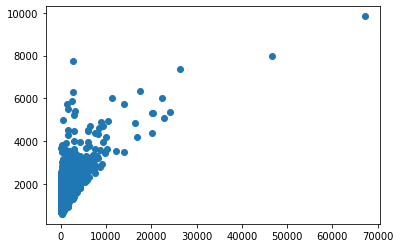

In [ ]:
plt.scatter(cout_train, model_cout.predict(X_cout_train))

In [ ]:
model_cout.predict(X_cout_train)

array([2203.71243056, 1359.69650697, 1687.52056121, ..., 1224.13454465,
       1182.59649502, 1279.99727237])

In [ ]:
cout_train

10132    2154
7918      772
4885     1030
3429      347
4851      102
         ... 
1585     1093
7734      390
9167      223
5578     1244
5734      121
Name: CHARGE, Length: 1120, dtype: int64

# **Modèle final**

In [ ]:
final_pred_train = model_freq.predict(X_train) * model_cout.predict(X_train) 
print(stats.describe(final_pred_train))

final_pred_test = model_freq.predict(X_test) * model_cout.predict(X_test) 
print(stats.describe(final_pred_test))

DescribeResult(nobs=8396, minmax=(61.444629429797864, 1483.794030713851), mean=245.63322862169733, variance=17310.489319554363, skewness=2.58158173606543, kurtosis=11.197610860665502)
DescribeResult(nobs=2100, minmax=(69.25413025403347, 1268.118014396514), mean=250.0614123763706, variance=17063.317597535737, skewness=2.33422567654709, kurtosis=8.502286556392187)


In [ ]:
print("Total coût sinistres", y_train.sum())
print("Total primes calculées par le modèle", final_pred_train.sum())

print("Total coût sinistres", y_test.sum())
print("Total primes calculées par le modèle", final_pred_test.sum())

Total coût sinistres 2038657
Total primes calculées par le modèle 2062336.5875077709
Total coût sinistres 522529
Total primes calculées par le modèle 525128.9659903783


In [ ]:
with open('encoder.pkl', 'wb') as file:
  pickle.dump(encoder, file)
with open('model_freq.pkl', 'wb') as file:
  pickle.dump(model_freq, file)
with open('model_cout.pkl', 'wb') as file:
  pickle.dump(model_cout, file)